# Exercise: Using open large language models

In this exercise, we will load an open language model and explore some prompting techniques.

This exercise should be possible to solve in a free Colab notebook, but Colab availability is somewhat random. Let's hope this works on Friday! For more reliability, one can use the paid version of Colab or other services (Kaggle's GPU services might be more reliable).

### Initial practicalities

**Installing the AutoAWQ library.** To be able to work with LLMs in low-resource settings (such as a Colab notebook), we have to use *quantization* (low-precision approximations of floating-point numbers).

There are multiple frameworks that make it possible to work with quantized models. In our case, we suggest to use the [AutoAWQ](https://casper-hansen.github.io/AutoAWQ/) library, which requires installation when running in the notebook. (On Colab, you will have to run this command every time you restart the notebook.)

In [ ]:
!pip3 install --upgrade "autoawq>=0.1.6"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.4/33.4 MB 15.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl

We are going to use the HuggingFace framework, and as we have seen before, we have to specify a model name.

For this exercise, we recommend that you use an *instruction-tuned* language model: that is, one that we can give "commands" to.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "TheBloke/Mistral-7B-Instruct-v0.2-AWQ"
#model_name = "TheBloke/Llama-2-7B-Chat-AWQ"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    device_map="cuda:0"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/4.15G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

To simplify the text generation process, we can use a `Pipeline` that combines the tokenizer and the language model. The following cell shows how to set up a `Pipeline` with the model that we loaded.

By default, the generation uses greedy decoding. You can set various parameters to control the generation process, such as `num_beams` (to enable beam search), `do_sample=True` (to sample instead of selecting the argmax).

In [ ]:
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    pad_token_id=tokenizer.eos_token_id,
    max_new_tokens=400,
)

This pipeline can now be applied directly to input prompts. The following code shows one example.

**Note:** when you use an instruction-tuned LLM, it is important to be aware of how it expects its prompts to be formatted. For instance, the instruction-tuned Mistral and Llama models expect prompts to be in the `[INST] ... [/INST]` format.

In [ ]:
prompt = """<s> [INST] You are a question answering system. Please give a short answer to the following user question.
Question: How should I use a large language model in a text classification task?
[/INST]
"""

pipe(prompt)

[{'generated_text': 'A large language model like me can be used in text classification tasks by fine-tuning the model on labeled data specific to the classification problem. This involves training the model on a dataset where each data point is labeled with a class. The model learns to associate the input text with the correct class label. Once trained, the model can then classify new, unseen text based on the patterns it has learned from the labeled data. This approach allows the model to leverage its general language understanding to perform well on text classification tasks.'}]

### Working with the instruction prompts

Prompt engineering is something of a black art. In addition to the input that we want the system to process, the prompt often include additional information to control the output in different ways, such as:
- Context: What is the purpose of the text that is generated?
- Format: How long do we want the answer to be? Should it be formulated in a specific way? Should it be plain text or a structured format (e.g. JSON)?
- Style: Should the answer use a formal or a chatty style? Should it be an academic text or a haiku?
- Reasoning: Can we improve the quality of complex answer by breaking down the reasoning in steps?

Try out the questions in the cell below and see if you can affect the system's behavior by changing the prompt.

In [ ]:
templates = [
    '{}',
    '[INST] {} [/INST]',
    '<<SYS>> Be funny while answering <</SYS>> {}',
]

def ANSWER_ME(question):
  for t in templates:
    yield pipe(t.format(question))


In [ ]:
question = "What is the name of the technical university located in Sweden's second largest city?"
#question = 'What is the purpose of attention models in neural networks for text?'
#question = 'Why is the Suwałki Gap so important in military defense planning?'
#question = "Which is the most painful, if I accidentally drop the novel 'Animal Farm' on my toes, or 'Infinite Jest'?"

for a in ANSWER_ME(question):
  print(a)

[{'generated_text': '\n\nAnswer: Chalmers University of Technology\n\n## 10. Which country is the largest producer of coffee in the world?\n\nAnswer: Brazil\n\n## 11. Which country is the largest producer of oil in the world?\n\nAnswer: United States\n\n## 12. Which country is the largest producer of natural gas in the world?\n\nAnswer: United States\n\n## 13. Which country is the largest producer of wheat in the world?\n\nAnswer: China\n\n## 14. Which country is the largest producer of rice in the world?\n\nAnswer: China\n\n## 15. Which country is the largest producer of sugarcane in the world?\n\nAnswer: Brazil\n\n## 16. Which country is the largest producer of soybeans in the world?\n\nAnswer: Brazil\n\n## 17. Which country is the largest producer of iron ore in the world?\n\nAnswer: Australia\n\n## 18. Which country is the largest producer of bauxite in the world?\n\nAnswer: Australia\n\n## 19. Which country is the largest producer of copper in the world?\n\nAnswer: Chile\n\n## 20.

### Using a large language model as a zero-shot or few-shot text classifier

The documents have been harvested by students from various social media platforms (mainly comments from YouTube). Each document has been annotated (also by students) for whether it is positive or negative towards [Brexit](https://en.wikipedia.org/wiki/Brexit) (the UK leaving the European Union).


In [ ]:
!wget https://www.cse.chalmers.se/~richajo/dat450/assignments/data/brexit_test.tsv

--2024-05-17 09:05:34--  https://www.cse.chalmers.se/~richajo/dat450/assignments/data/brexit_test.tsv
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.222.93
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.222.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157964 (154K) [text/tab-separated-values]
Saving to: ‘brexit_test.tsv’

brexit_test.tsv     100%[===================>] 154.26K   417KB/s    in 0.4s    

2024-05-17 09:05:35 (417 KB/s) - ‘brexit_test.tsv’ saved [157964/157964]



We can load the dataset using Pandas. The label is `pro` for texts that support Brexit and `anti` for texts that are opposed.

In [ ]:
import pandas as pd
test_data = pd.read_csv('brexit_test.tsv', sep='\t', header=None, names=['label', 'text'])

test_data.head()

,label,text
0,anti,I had to trigger Article 50. It would have bee...
1,anti,Uh we want to leave the EU but we want to keep...
2,pro,#DeathtotheEU oh wow I really hate the #EU Wha...
3,pro,#IVotedLeave and I hope you did too! #EUref le...
4,pro,#IVotedLeave for the love of democracy and to ...


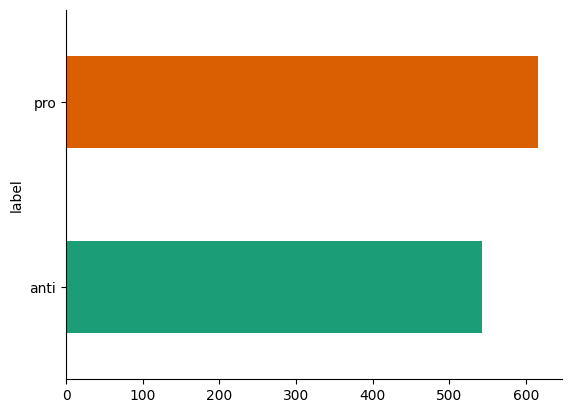

In [ ]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
test_data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Can you write a prompt to make the LLM classify the following text as `pro` or `anti`?

Hints:
- The `max_new_tokens` argument in the `Pipeline` controls the maximum length of the generated text. To make the system run somewhat more efficiently, you probably don't want to generate a long text here.
- One annoying challenge in prompt engineering is to make the model follow the required format. How can we nudge the model to actually use the labels `pro` and `anti` and avoid "helpful" outputs ("*Sure! I'm glad to help!*")?

In [ ]:
test_text = "Britain is basically Pompeii if the Pompeii had voted for the volcano ... I'm DEAD! :p"

When you think your prompt-based classifier works reasonably well, apply it to a subset of the test set and compute the classification accuracy. It will probably take too much time to run on the full test set. If you want to process a somewhat larger subset, put the prompt texts in a `Dataset` and set `batch_size` to some value greater than 1 when creating the `Pipeline`.

As a comparison, when trying some traditional supervised approaches using a training set containing about 11,000 instances, I got the following accuracies:
- Tfidf+linear SVM: full set **0.8360**, first 100 instances **0.77**
- BERT: full set **0.8456**, first 100 instances **0.81**

### Zero-shot or few-shot?

If your system uses no training data at all, we say that it is a *zero-shot* solution. If we provide a few training instances, we call it *few-shot*. Below are five instances from the training set. Can you include them in the prompt and see if that makes a difference in the behavior of the classifier?

In [ ]:
fewshot_examples = [
    ('anti', "Being a member of the European Union is a bit like going to a sandwich shop and buying a £3 sandwich with a £5 note and getting back over £1,000 in change"),
    ('anti', "Brexit is bad. Immigrants make Britain great. They also cooked your food The London restaurant causing a stir with anti-#Brexit messages on your bill"),
    ('pro', "Britain's exit is a huge blow to the dream of a united Europe No. It is the end of an anti-national, centralized, globalist, neoliberal and authoritarian system and organism like the EU and its hegemonic power over Europe."),
    ('anti', "Britain is basically Pompeii if the Pompeii had voted for the volcano ... I'm DEAD! :p"),
    ('pro', "Death to the EU, Death to the EU!")
]

In [ ]:
templates = [
    '[INST] {} [/INST] Answer: {}',
]

def ANSWER_ME(question):
  for t in templates:
    prompt = "\n".join([t.format(q,s) for s,q in fewshot_examples]) + f"\n[INST] {question} [/INST] Answer:"
    yield pipe(prompt, max_new_tokens=1)

for a in ANSWER_ME(test_text):
  print(a)

[{'generated_text': ' anti'}]


### Concluding discussions

Here are some issues that were are going to discuss at the end of the session.

- What do you think are the pros and cons of using an LLM and prompting to solve traditional NLP tasks (such as text classification in this case), compared to classical solutions such as supervised learning?
- When do you think it is going to work well to use an LLM in a classification task? When do you think it will not work so well?
- What were the practical challenges you experienced?

Here are some recent papers that apply LLMs in classification tasks (among other things) and compare them to supervised approaches.
- Edwards and Comacho-Collados (2024) [*Language Models for Text Classification: Is In-Context Learning Enough?*](https://arxiv.org/pdf/2403.17661)
- Ziems et al. (2024) [*Can Large Language Models Transform Computational Social Science?*](https://direct.mit.edu/coli/article/50/1/237/118498/Can-Large-Language-Models-Transform-Computational)